In [1]:
import requests
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from bs4 import BeautifulSoup

status_codes = requests.status_codes.codes

In [2]:
seasons = [str(year) for year in range(2021, 2023)]
print(seasons)

regression_columns = ['1B', '2B', '3B', 'HR', 'HBP+BB', 'SB', 'CS']
target = 'R'

['2021', '2022']


In [3]:
not_integer_columns = ['Team']
header_columns = ['Team', 'G', 'PA', 'AB', 'R', 'H', '2B', '3B', 'HR', 'RBI', 'SB', 'CS', 'BB', 'SO', 'TB', 'GDP', 'HBP', 'SH', 'SF', 'IBB', 'LOB']

def parse_standings_table(content):
    stats = []

    rows = BeautifulSoup(content).select('.stats_table tbody tr')
    for row in rows:
        if 'class' in row.attrs:
            continue

        columns = [row.select('th a')[0]] + row.select('td')

        observations = dict(
            zip(
                header_columns, 
                map(lambda a: a.text, [columns[0]] + columns[4:17] + columns[22:29])
            )    
        )

        stats.append(observations)

    df = pd.DataFrame(stats)
    for col in df.columns:
        if col in not_integer_columns:
            continue

        df[col] = df[col].astype(int)

    return df

In [4]:
def get_seasons(seasons, transformations):
    df = None

    for season in seasons:
        response = requests.get(f'https://www.baseball-reference.com/leagues/majors/{season}.shtml')

        if response.status_code != status_codes['ok']:
            raise Exception('no!!!!')

        df_season = parse_standings_table(response.content)
        df_season['Season'] = season

        if df is None:
            df = df_season
        else:
            df = pd.concat([df, df_season])


    for transformation in transformations:
        df = transformation(df)

    return df

In [5]:
def double_plus_triple(df):
    df['2B+3B'] = df['2B'] + df['3B']
    return df

def single(df):
    df['1B'] = df['H'] - (df['2B'] + df['3B'] + df['HR'])
    return df

def hbp_plus_bb(df):
    df['HBP+BB'] = df['HBP'] + df['BB']
    return df

In [6]:
df = get_seasons(seasons, [
    single,
    hbp_plus_bb,
    double_plus_triple,
])

df

,Team,G,PA,AB,R,H,2B,3B,HR,RBI,...,GDP,HBP,SH,SF,IBB,LOB,Season,1B,HBP+BB,2B+3B
0,Arizona Diamondbacks,162,6144,5489,679,1297,308,31,144,644,...,99,54,32,28,24,1152,2021,814,591,339
1,Atlanta Braves,161,6056,5363,790,1307,269,20,239,762,...,81,67,32,43,36,1072,2021,779,616,289
2,Baltimore Orioles,162,5983,5420,659,1296,266,15,195,632,...,105,65,14,31,12,1046,2021,820,516,281
3,Boston Red Sox,162,6122,5495,829,1434,330,23,219,783,...,100,61,10,42,22,1093,2021,862,573,353
4,Chicago Cubs,162,5972,5306,705,1255,225,26,210,672,...,133,92,40,30,17,1019,2021,794,594,251
5,Chicago White Sox,162,6084,5357,796,1373,275,22,190,757,...,139,78,24,39,10,1125,2021,886,664,297
6,Cincinnati Reds,162,6162,5423,786,1352,295,13,222,756,...,129,105,35,45,22,1110,2021,822,658,308
7,Cleveland Indians,162,5907,5332,717,1269,248,22,203,686,...,105,64,20,36,18,987,2021,796,517,270
8,Colorado Rockies,161,6007,5374,739,1338,275,34,182,709,...,98,58,48,36,24,1074,2021,847,549,309
9,Detroit Tigers,162,5979,5376,697,1299,236,37,179,675,...,113,44,17,50,8,1031,2021,847,534,273


In [7]:
corr = df[[target] + regression_columns].corr()
corr

,R,1B,2B,3B,HR,HBP+BB,SB,CS
R,1.000000,0.108313,0.545314,-0.174907,0.782613,0.605161,-0.138213,-0.248549
1B,0.108313,1.000000,0.318812,0.047699,-0.287154,-0.315436,-0.124677,-0.080625
2B,0.545314,0.318812,1.000000,-0.108932,0.121908,0.128249,-0.293802,-0.255625
3B,-0.174907,0.047699,-0.108932,1.000000,-0.357461,-0.180243,0.233613,0.218827
HR,0.782613,-0.287154,0.121908,-0.357461,1.000000,0.547064,-0.045043,-0.183756
HBP+BB,0.605161,-0.315436,0.128249,-0.180243,0.547064,1.000000,-0.203806,-0.185738
SB,-0.138213,-0.124677,-0.293802,0.233613,-0.045043,-0.203806,1.000000,0.566592
CS,-0.248549,-0.080625,-0.255625,0.218827,-0.183756,-0.185738,0.566592,1.000000


<AxesSubplot:>

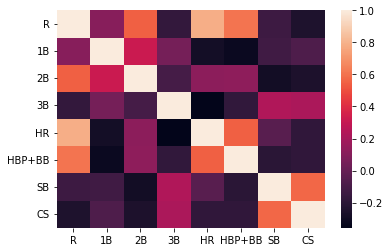

In [8]:
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values)

In [9]:
def setup_model(df):
    y = df[target]
    X = sm.add_constant(df.loc[:, regression_columns])

    return X, y

X, y = setup_model(df)

est = sm.OLS(y, X)
est = est.fit()

In [10]:
print('p-values')
{ column: (est.pvalues[i], est.pvalues[i] < .05) for i, column in enumerate(X.columns) }

p-values


{'const': (3.4529194929011447e-07, True),
 '1B': (3.4101811378238198e-09, True),
 '2B': (4.157485246170922e-12, True),
 '3B': (0.0005043864556983208, True),
 'HR': (7.050666133044627e-21, True),
 'HBP+BB': (1.5247859564862714e-08, True),
 'SB': (0.10428744374417906, False),
 'CS': (0.6330702320183421, False)}

In [11]:
print(est.summary())

                            OLS Regression Results                            
Dep. Variable:                      R   R-squared:                       0.935
Model:                            OLS   Adj. R-squared:                  0.926
Method:                 Least Squares   F-statistic:                     106.4
Date:                Mon, 26 Dec 2022   Prob (F-statistic):           1.58e-28
Time:                        05:33:43   Log-Likelihood:                -260.42
No. Observations:                  60   AIC:                             536.8
Df Residuals:                      52   BIC:                             553.6
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -357.5865     61.240     -5.839      0.0

In [12]:
df_pred = df.loc[:, ['Team', 'R']]

df_pred['PRED_R'] = est.predict(X)
df_pred['ABS_DIFF'] = (df_pred.R - df_pred.PRED_R).abs()

df_pred.head()

,Team,R,PRED_R,ABS_DIFF
0,Arizona Diamondbacks,679,688.713207,9.713207
1,Atlanta Braves,790,778.302548,11.697452
2,Baltimore Orioles,659,683.092601,24.092601
3,Boston Red Sox,829,820.085221,8.914779
4,Chicago Cubs,705,704.377569,0.622431


In [13]:
print('off by an average of:', df_pred.ABS_DIFF.mean(), 'runs')

off by an average of: 15.648752733079599 runs
